In [478]:
import numpy as np
import matplotlib.pyplot as plt

We formulate $\mathrm{La1_{x}La2_{\frac{4}{3}-x}TiO_{3}}$.

# Empirically determined parameters

In [479]:
# X-ray wavelength lambda (A)
l = 1.54059

In [480]:
# Parameters of coherent scattering analytically approximated by 5 Gaussians
# https://doi.org/10.1107/S0108767394013292

# Oxygen
a_O = (
    2.960427,
    2.508818,
    0.637853,
    0.722838,
    1.142756,
)
b_O = (
    14.182259,
    5.936858,
    0.112726,
    34.958481,
    0.390240,
)
c_O = 0.027014


# Lanthanum
a_La = (
    19.966018,
    27.329654,
    11.018425,
    3.086696,
    17.335454,
)
b_La = (
    3.197408,
    0.003446,
    19.955492,
    141.381979,
    0.341817,
)
c_La = -21.745489


# Titanium
a_Ti = (
    9.818524,
    1.522646,
    1.703101,
    1.768774,
    7.082555,
)
b_Ti = (
    8.001879,
    0.029763,
    39.885423,
    120.158000,
    0.532405,
)
c_Ti = 0.102473


# Strontium
a_Sr = (
    17.730219,
    9.795867,
    6.099763,
    2.620025,
    0.600053,
)
b_Sr = (
    1.563060,
    14.310868,
    0.120574,
    135.771315,
    0.120574,
)
c_Sr = 1.140251

In [481]:
# cubic multiplicities
def M_cub(hkl):
    # todo stop using the check as the function
    STO_M = {
    '001': 6,
    '110' : 12,
    '111' : 8,
    '200' : 6,
    '211' : 24,
    '201' : 24,
    '220' : 12,
    '221' : 24,
    '300' : 6,
    '310' : 24,
    '311' : 24,
    '222' : 8,
    }
    return STO_M[hkl]

# perfect perovskite basis
pA = (0, 0, 0)
pB = (0.5, 0.5, 0.5)
pX1 = (0, 0.5, 0.5)
pX2 = (0.5, 0, 0.5)
pX3 = (0.5, 0.5, 0)

Attributes, grouped by compound:
- Atomic positional parameters
- lattice params
- multiplicity

In [482]:
# La1_{4/3-x}La_{x}TiO3
# src: cif source article

# (x,y,z)
La1 = (0,0,0.5)
La2 = (0,0,0)
Ti1 = (0.5, 0.5, 0.2594)
Ti2 = (0.5, 0.5, 1 - 0.2594)
O1 = (0.5,0.5,0.5)
O2 = (0,0.5,0.23)
O3 = (0.5,0,0.2412)
O4 = (0.5,0.5,0)
O5 = (0,0.5,1-0.23)
O6 = (0.5,0,1-0.2412)
# O7 = (0,0,0)
# O8 = (0,0,1)


# Lattice parameters
a = 3.87890
b = 3.86680
c = 7.78660
LTO_abc = (a, b, c)



In [483]:
def M_double_perov(hkl):

    # count how many of h,k,l are not zero
    nonzero_cnt = 0
    for i in hkl:
        if i != '0':
            nonzero_cnt += 1

    return np.power(2,nonzero_cnt)

In [484]:
# SrTiO3
# src: cif source article

# STO Lattice parameters
a = 3.90527
abc_STO = (a,a,a)

# Functions applicable to all structures

### $hkl$ to $\frac{\sin\theta}{\lambda}$
We find $\frac{\sin\theta}{\lambda}$ from $hkl$ by the interplanar spacing equation
$$
d=\frac{a}{\sqrt{ h^{2}+\left( \frac{a}{b}\cdot k \right)^{2}+\left( \frac{a}{c}\cdot l \right)^{2} }}
$$
which combined with Bragg's law gives
$$
\frac{\sin\theta}{\lambda}=\frac{1}{2d}=\frac{\sqrt{ h^{2}+\left( \frac{a}{b}\cdot k \right)^{2}+\left( \frac{a}{c}\cdot l \right)^{2} }}{2a}
$$

In [485]:
'''
Calculates sin(theta)/lambda (which I call angle data) as a function of hkl given a,b,c
@param abc string
@param hkl string
'''
def sintheta_over_lambda(abc, hkl):
    h = int(hkl[0])
    k = int(hkl[1])
    l = int(hkl[2])
    a = abc[0]
    b = abc[1]
    c = abc[2]

    return np.sqrt(h**2 + (a*k/b)**2 + (a*l/c)**2) / (2*a)



In [486]:
def sintheta(abc,hkl):
    return l * sintheta_over_lambda(abc,hkl)

def costheta(abc,hkl):
    return np.sqrt(1 - sintheta(abc,hkl)**2)

Negligible difference: [ 2.07390836e-07 -6.29389442e-07 -4.36775288e-07 -3.70398693e-07
 -9.00687379e-07 -8.39515982e-07]


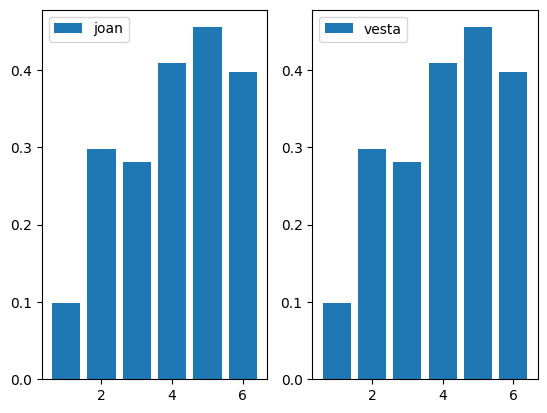

In [487]:
# check

j_sintheta = (
    sintheta(LTO_abc,'001'),
    sintheta(LTO_abc,'111'),
    sintheta(LTO_abc,'110'),
    sintheta(LTO_abc,'201'),
    sintheta(LTO_abc,'211'),
    sintheta(LTO_abc,'200'),
)

v_2theta = (
    11.3546,
    34.6957,
    32.6736,
    48.3226,
    54.1569,
    46.8031
)

v_sintheta = np.sin(np.array(v_2theta) / 2 * 2 * np.pi / 360)

print(f'Negligible difference: {np.array(j_sintheta) - np.array(v_sintheta)}')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar((1,2,3,4,5,6),j_sintheta,label='joan')
ax1.legend()
ax2.bar((1,2,3,4,5,6),v_sintheta,label='vesta')
ax2.legend()

### Lorentz polarization
We formulate the Lorentz-polarization factor as $$
\frac{{1+\cos(2\theta)^{2}}}{\sin(\theta)^{2}\cos(\theta)}.
$$
src: XRD book
Conflicts with international tables

In [488]:
'''
Lorentz-polarization factor at direction hkl
@param hkl string
'''
def lorentz(hkl,abc):
    return (2+ 4*costheta(abc,hkl)**4 - 4*costheta(abc,hkl)**2)/(sintheta(abc,hkl)**2 * costheta(abc,hkl))


### Coherent scattering atomic form factor
$f(\theta)$ is the coherent scattering factor. Its intensity as a function of $\theta$ is analytically approximated by $N=5$ gaussians:
$$f_0 (\sin \theta / \lambda ) = \sum _{i=1}^N a_i \exp \left ( −b_i \frac {\sin ^2 \theta }{ \lambda ^2} \right ) + c.$$
The 11 params $a_{i},b_{i},c$ are defined & cited up there.

In [489]:
'''
Atomic form factors of given atom (Coherent scattering)
 @param hkl string
 @param ai string
 @param bi string
 @param c float
 @param abc lattice parameters; required to calculate sin(theta)/lambda
'''
def f(hkl,ai,bi,c,abc):
    f0 = c
    for i in range(5):
        f0 += ai[i] * np.exp(- bi[i] * sintheta_over_lambda(abc, hkl) ** 2)
    return f0

### Exp of Atomic positional factor

$$\exp \bigl [ 2\pi \mathrm {i} \big ( hx_j + ky_j + lz_j \big ) \bigr ]$$

In [490]:
'''
Exponent containing atomic positional params in structure factor
 @param hkl string
 #param xyz string
'''
def exphkl(hkl,xyz):
    h = int(hkl[0])
    k = int(hkl[1])
    l = int(hkl[2])

    ans = np.exp(2 * np.pi * 1j * (h*xyz[0] + k*xyz[1] + l*xyz[2]))

    return ans

In [491]:
def O_collective(hkl):
    ans = exphkl(hkl,O4) + exphkl(hkl,O2) + exphkl(hkl,O3) + exphkl(hkl,O1)
    print(f'{hkl}     {np.real(ans)}    {np.imag(ans)}')
    return ans

In [492]:
O_collective('001')
O_collective('002')
O_collective('003')
O_collective('004')
O_collective('005')


001     0.18059709536123147    1.990586486383686
002     0.03752502771278865    0.3590487006412464
003     -0.5332410138675361    -1.9160505625253943
004     3.8519485446200292    -0.7011231161084418
005     0.8607371878097987    1.771044665961034


(0.8607371878097987+1.771044665961034j)

## Intensity

$$I_{hkl}=\mathrm{Multiplicity} \cdot \frac{{1+\cos(2\theta)^{2}}}{\sin(\theta)^{2}\cos(\theta)}\cdot |S_{hkl}|^{2}$$
Intensity is herein formulated with multiplicity, the VESTA version of lorentz-polarization, and the structure factor. We are interested only in hkl-dependent features. The absorption factor and Debye-Waller temperature are neglected.

In [493]:
'''
 intensity of the peak hkl when La distribution described by x
 @param hkl string
 @param x float
 @param M dict
 @param S(hkl,x)
'''
def I(hkl,abc,x,M,S):
    return M(hkl) * lorentz(hkl,abc) * (np.absolute(S(hkl, x)) ** 2)

# Structure-specific functions

### L2/3TO: Order parameter and structure factor
Translate $x$ in $\mathrm{La1_{x}La2_{\frac{4}{3}-x}TiO_{3}}$ to Uchino's order parameter $\sigma$.
$$S=(x)F_{\text{La1}}+\left( \frac{4}{3}-x \right)F_{\text{La2}}+F_{\text{Ti}}+F_{\text{O}}$$


In [494]:
'''
Calculates Uchino's order parameter given x
@param x float
'''
def sigma(x):
    return 2-3*x

def x_from_sigma(sigma):
    return (2-sigma)/3

In [495]:
'''
La2/3TiO3 Structure factor of the peak hkl, containing all basis atoms, when La distribution described by x
 @param hkl string
 @param x float
'''
def L2p3TO_S(hkl, x):
    ans = x * f(hkl,a_La,b_La,c_La,LTO_abc) * exphkl(hkl,La1) \
          + (4/3 - x) * f(hkl,a_La,b_La,c_La,LTO_abc) * exphkl(hkl,La2) \
          + f(hkl,a_Ti,b_Ti,c_Ti,LTO_abc) * (exphkl(hkl, Ti1)+exphkl(hkl, Ti2)) \
          + f(hkl,a_O,b_O,c_O,LTO_abc) * (exphkl(hkl,O1) + exphkl(hkl,O2) + exphkl(hkl,O3) + exphkl(hkl,O4) + exphkl(hkl,O5) + exphkl(hkl,O6)) # six basis O atoms
    return ans

### STO structure factor
$$S=F_{\text{Sr}}+F_{\text{Ti}}+F_{\text{O}_{1,2,3}$$
VESTA included only 1 oxygen basis atom. However, I am not convinced that one can produce all require oxygens under m-3m or 4/mm.m transformations. I am going with the reduced unit cell which has three O atoms.

In [496]:
'''
La2/3TiO3 Structure factor of the peak hkl, containing all basis atoms, when La distribution described by x
 @param hkl string
 @param x float (dummy var)
'''
def STO_S(hkl, x):
    ans = f(hkl,a_Sr,b_Sr,c_Sr,abc_STO) * exphkl(hkl, pA) \
          + f(hkl,a_O,b_O,c_O,abc_STO) * (exphkl(hkl, pX1) + exphkl(hkl, pX2) + exphkl(hkl, pX3)) \
          + f(hkl,a_Ti,b_Ti,c_Ti,abc_STO) * exphkl(hkl, pB)
    return ans

### LTO structure factor
$$S=F_{\text{La}}+F_{\text{Ti}}+F_{\text{O}_{1,2,3}$$


# Results

## STO Structure factor & Intensity match
Ignoring anomalous dispersion

Negligible difference: [-1.24054254e-06  2.73084510e-07  2.22582303e-05  3.39729732e-05
 -2.98050421e-06  2.81232009e-05]


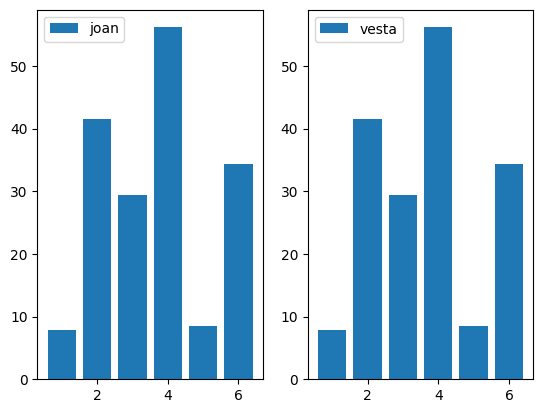

In [497]:
# Joan STO structure factors
x = 1 # dummy
s001 = np.absolute(STO_S('001',x))
s111 = np.absolute(STO_S('111',x))
s110 = np.absolute(STO_S('110',x))
s201 = np.absolute(STO_S('201',x))
s211 = np.absolute(STO_S('211',x))
s200 = np.absolute(STO_S('200',x))

s_joan = (s001, s110, s111, s200, s201, s211)

# VESTA STO structure factors
s_vesta = (
    7.92045,
    41.5026,
    29.4554,
    56.166,
    8.56659,
    34.2936,
)

print(f'Negligible difference: {np.array(s_vesta) - np.array(s_joan)}')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar((1,2,3,4,5,6),s_joan,label='joan')
ax1.legend()
ax2.bar((1,2,3,4,5,6),s_vesta,label='vesta')
ax2.legend()

plt.show()

[ 2.34056188e-07  4.50430843e-06  8.09525533e-07  1.72327426e-06
 -5.67428341e-08  1.54257137e-06  1.08212213e-06  2.08183345e-07
 -1.13269335e-05  5.92888913e-07  1.11218371e-07  5.75527748e-07]


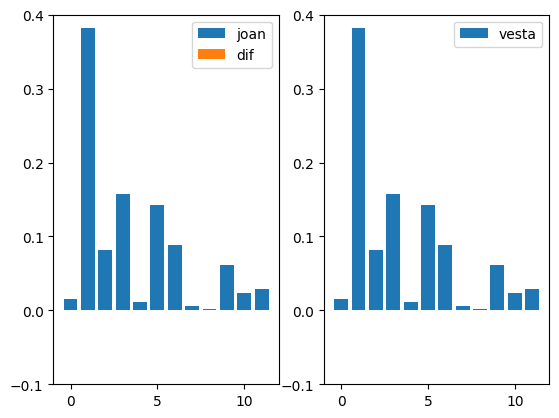

In [498]:
# Joan STO intensities
x = 1 # dummy
i001 = I('001',abc_STO,x,M_cub,STO_S)
i111 = I('111',abc_STO,x,M_cub,STO_S)
i110 = I('110',abc_STO,x,M_cub,STO_S)
i201 = I('201',abc_STO,x,M_cub,STO_S)
i211 = I('211',abc_STO,x,M_cub,STO_S)
i200 = I('200',abc_STO,x,M_cub,STO_S)
i220 = I('220',abc_STO,x,M_cub,STO_S)
i221 = I('221',abc_STO,x,M_cub,STO_S)
i300 = I('300',abc_STO,x,M_cub,STO_S)
i310 = I('310',abc_STO,x,M_cub,STO_S)
i311 = I('311',abc_STO,x,M_cub,STO_S)
i222 = I('222',abc_STO,x,M_cub,STO_S)

i_joan = (i001,i110,i111,i200,i201,i211,i220,i221,i300,i310,i311,i222)


# VESTA STO intensities without anomalous dispersion
i_vesta = (
    3.8539,
    100,
    21.2008,
    41.1848,
    2.9237,
    37.4292,
    23.1229,
    1.4643,
    0.3631,
    15.8968,
    6.3035,
    7.7040,
)


# normalize
i_joan = np.array(i_joan)
i_joan = i_joan/i_joan.sum()
i_vesta = np.array(i_vesta)
i_vesta = i_vesta/i_vesta.sum()

dif = i_vesta - i_joan

# plot
n = len(i_vesta) # = len(i_joan)
ymin = -0.1
ymax = 0.4

print(dif)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(np.arange(n),i_joan,label='joan')
ax1.bar(np.arange(n),dif,label='dif')
ax1.legend()
ax1.set_ylim([ymin, ymax])

ax2.bar(np.arange(n),i_vesta,label='vesta')
ax2.legend()
ax2.set_ylim([ymin, ymax])

plt.show()

## La2p3TiO3 Structure factor & intensity match

A small difference: [-0.08654076 -2.57728209 -0.74806506 -6.02064131 -1.45543717 -1.48742803]


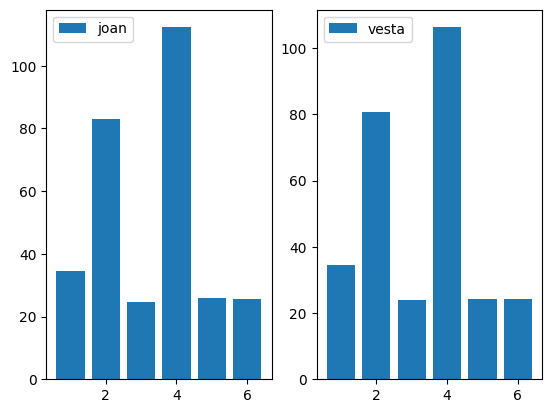

In [499]:
# Joan La2/3TiO3 structure factors
x = 0.353 # src default
s001 = np.absolute(L2p3TO_S('001',x))
s111 = np.absolute(L2p3TO_S('111',x))
s110 = np.absolute(L2p3TO_S('110',x))
s201 = np.absolute(L2p3TO_S('201',x))
s211 = np.absolute(L2p3TO_S('211',x))
s200 = np.absolute(L2p3TO_S('200',x))

s_joan = (s001, s110, s111, s200, s201, s211)

# VESTA Ls2/3TiO3 structure factors
s_vesta = (
    34.4102,
    80.5659,
    23.8959,
    106.264,
    24.3273,
    24.2415,
)

print(f'A small difference: {np.array(s_vesta) - np.array(s_joan)}')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar((1,2,3,4,5,6),s_joan,label='joan')
ax1.legend()
ax2.bar((1,2,3,4,5,6),s_vesta,label='vesta')
ax2.legend()

plt.show()


A small difference: [-0.04112925 -2.52188209  0.16253985 -5.90064131  0.44721832 -0.29141176]


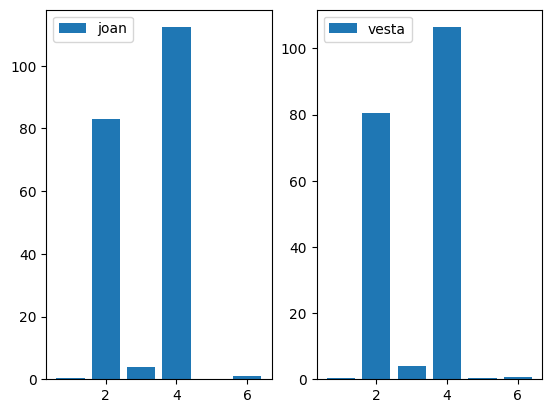

In [500]:
# Joan La2/3TiO3 structure factors
x = 2/3 # unordered
s001 = np.absolute(L2p3TO_S('001',x))
s111 = np.absolute(L2p3TO_S('111',x))
s110 = np.absolute(L2p3TO_S('110',x))
s201 = np.absolute(L2p3TO_S('201',x))
s211 = np.absolute(L2p3TO_S('211',x))
s200 = np.absolute(L2p3TO_S('200',x))

s_joan = (s001, s110, s111, s200, s201, s211)

# VESTA Ls2/3TiO3 structure factors
s_vesta = (
    0.284413,
    80.6213,
    4.15069,
    106.384,
    0.464089,
    0.699209,
)

print(f'A small difference: {np.array(s_vesta) - np.array(s_joan)}')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar((1,2,3,4,5,6),s_joan,label='joan')
ax1.legend()
ax2.bar((1,2,3,4,5,6),s_vesta,label='vesta')
ax2.legend()

plt.show()

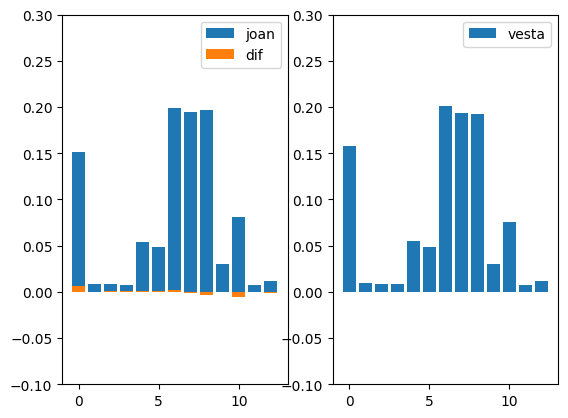

In [501]:
x = 0.353 # VESTA src set
i001 = I('001', LTO_abc, x,M_double_perov, L2p3TO_S)
i002 = I('002', LTO_abc, x,M_double_perov, L2p3TO_S)
i100 = I('100', LTO_abc, x,M_double_perov, L2p3TO_S)
i010 = I('010', LTO_abc, x,M_double_perov, L2p3TO_S)
i101 = I('101', LTO_abc, x,M_double_perov, L2p3TO_S)
i011 = I('011', LTO_abc, x,M_double_perov, L2p3TO_S)
i102 = I('102', LTO_abc, x,M_double_perov, L2p3TO_S)
i012 = I('012', LTO_abc, x,M_double_perov, L2p3TO_S)
i110 = I('110', LTO_abc, x,M_double_perov, L2p3TO_S)
i111 = I('111', LTO_abc, x,M_double_perov, L2p3TO_S)
i200 = I('200', LTO_abc, x,M_double_perov, L2p3TO_S)
i201 = I('201', LTO_abc, x,M_double_perov, L2p3TO_S)
i211 = I('211', LTO_abc, x,M_double_perov, L2p3TO_S)

i_joan = (i001,i002,i100,i010,i101,i011,i102,i012,i110,i111,i200,i201,i211,)

# VESTA STO intensities without anomalous dispersion
i_vesta = (
    78.4035,
    4.5339,
    4.2549,
    4.4403,
    27.4602,
    24.4494,
    100,
    96.5008,
    96.0481,
    14.8313,
    37.6612,
    3.6716,
    5.6252,
)

# normalize
i_joan = np.array(i_joan)
i_joan = i_joan/i_joan.sum()
i_vesta = np.array(i_vesta)
i_vesta = i_vesta/i_vesta.sum()

dif = i_vesta - i_joan

# plot
n = len(i_vesta) # = len(i_joan)
ymin = -0.1
ymax = 0.3

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(np.arange(n),i_joan,label='joan')
ax1.bar(np.arange(n),dif,label='dif')
ax1.legend()
ax1.set_ylim([ymin, ymax])

ax2.bar(np.arange(n),i_vesta,label='vesta')
ax2.legend()
ax2.set_ylim([ymin, ymax])

plt.show()

# Intensity predictions

## Thin film XRD intensity

$$I_{hkl}=\frac{{1+\cos(2\theta)^{2}}}{\sin(\theta)^{2}\cos(\theta)}\cdot |S_{hkl}|^{2}$$
Modifications to powder XRD:
- the multiplicity factor is now uniformly 1 for all hkl
- the polarization factor stays (https://dictionary.iucr.org/Lorentz%E2%80%93polarization_correction)
- the Lorentz factor, I think it should get rid of a sintheta on the denominator. not sure though (http://clay.uga.edu/courses/8550/Reynolds_1986.pdf)

Version 2:
$$I_{hkl}=\frac{{1+\cos(2\theta)^{2}}}{\sin(\theta)\cos(\theta)}\cdot |S_{hkl}|^{2}$$

In [502]:
'''
 intensity of the peak hkl when La distribution described by x
 @param hkl string
 @param x float
 @param M dict
 @param S(hkl,x)
'''
def thin_I(hkl,abc,x,S):
    return lorentz(hkl,abc) * (np.absolute(S(hkl, x)) ** 2)

def thin_I2(hkl,abc,x,S):
    return lorentz(hkl,abc) * sintheta(abc,hkl) * np.absolute(S(hkl, x)) ** 2

In [503]:
'''
La2p3TiO3 intensity shortcut. Increase robustness, decrease mem efficiency.
- using lorentz v1.
@param s input order param directly
'''
def LaI(hkl,s):
    return thin_I(hkl,LTO_abc,x_from_sigma(s),L2p3TO_S)

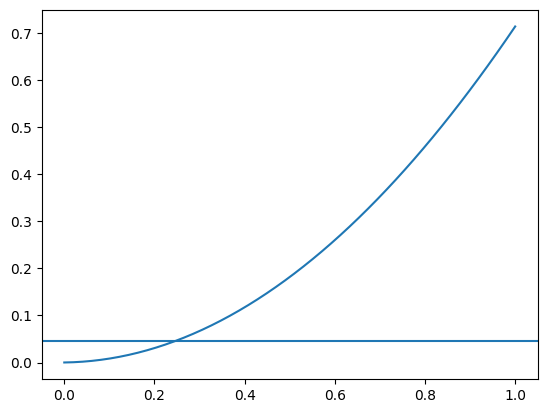

In [504]:
measured_small_peak_1 = 16.8
measured_big_peak_2 = 362.5

# for intercepting
s = np.linspace(0,1)
plt.plot(s,
         LaI('001',s)
       /(LaI('004',s)
        +LaI('200',s)
        +LaI('020',s)
        )
         )
plt.axhline(y=measured_small_peak_1/measured_big_peak_2)

In [505]:
# calculations v2
x = np.linspace(1/3,2/3,num=100)
s = sigma(x)

i001 = thin_I2('001', LTO_abc, x, L2p3TO_S)
i101 = thin_I2('101', LTO_abc, x, L2p3TO_S)
i111 = thin_I2('111', LTO_abc, x, L2p3TO_S)
i110 = thin_I2('110', LTO_abc, x, L2p3TO_S)
i201 = thin_I2('201', LTO_abc, x, L2p3TO_S)
i211 = thin_I2('211', LTO_abc, x, L2p3TO_S)
i200 = thin_I2('200', LTO_abc, x, L2p3TO_S)
i004 = thin_I2('004', LTO_abc, x, L2p3TO_S)
i020 = thin_I2('020', LTO_abc, x, L2p3TO_S)

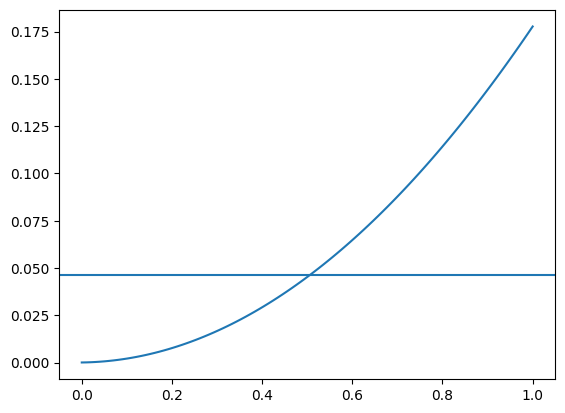

In [506]:
measured_small_peak_1 = 16.8
measured_big_peak_2 = 362.5

# for intercepting
plt.plot(s, i001 / (i200+i020+i004))
plt.axhline(y=measured_small_peak_1/measured_big_peak_2)